## **1. Business Understanding**

For this report, we will define the classification problem as predicting whether a driver will finish on the podium (top 3) in a given race based on pre-race and qualifying data from the Formula 1 World Championship (1950-2024) dataset from Kaggle. A value of 1 represents a podium finish (1st, 2nd, or 3rd place), while a value of 0 represents a non-podium finish (all other positions, including retirements or disqualifications). Features that may be used in the model include grid position, constructor (team), track characteristics, driver performance history, and season information.

The business case for this type of model is centered on forecasting and strategic decision-making. Racing teams could use such a model to estimate the likelihood of a podium finish before the race to guide strategy, such as pit stop planning or driver expectations. Broadcasters and analysts could use the predicted probabilities to enhance pre-race coverage with data-driven insights, while sponsors and advertisers could use these forecasters to assess expected driver visibiliy and exposure.

This type of model would be used primarily for offline analysis or pre-race forecasting, not for rela-time decision-making during a race. Because podium finishes are rarely rare events, the model does not need to achieve perfect accuracy to be valuable. Instead, its usefulness lies in performing better than a naive baseline (predicting "no podium"), providing some discriminative power to identify which drivers are more likely to place highly. Even a moderate level of accuracy would provide helpful insights for teams, broadcasters, and sponsors.

In [23]:
# Import any dependencies

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

### **1.2 Pre-processing**

- raceId: unique identifier for each race (categorical), one-hot encoded integer (ID variable)
- driverId: unique identifier for each driver (categorical), one-hot encoded integer (driver identity)
- constructorId: unique identifier for each constructor/team (categorical), one-hot encoded integer (team identity)
- grid: driver's starting position on the grid (ex, 1 = pole/1st place); numerical; integer, scaled
- year: year of the race (numerical); integer, scaled
- round: round number in the racing season (numerical); integer, scaled
- positionOrder: final finishing position of the driver (numerical); integer (used only to create target)
- podium (target): binary target including podium finish (1 = podium, 0 = not podium); categorical; binary integer/boolean

Below, we have all the CSVs loaded and we had chosen our variables from the four (results, races, drivers, and constructors). We did not consider columns such as *milliseconds*, *fastestLap*, and *status* because they depended on in-race events. Any rows that were missing *positionOrder* were dropped as these were essential for defining the target variable and key features.

The target variable for this task is **podium**, which indicates whether or not a driver finishes in the top 3 for a given race.
- ```podium = 1```: driver finished in position 1, 2, or 3
- ```podium = 0```: driver finished in any other positions, including DNFs (did not finish)

This variable is derived from the ```positionOrder``` column in the Formula 1 World Championship (1950-2024) dataset.

In [15]:
# Adapted from Tiffany Nguyen's Lab 1 submission for CS 5324.

results = pd.read_csv("/Users/tiffany/Desktop/CS 5324/CS 5324 Datasets/results.csv")
races = pd.read_csv("/Users/tiffany/Desktop/CS 5324/CS 5324 Datasets/races.csv")
drivers = pd.read_csv("/Users/tiffany/Desktop/CS 5324/CS 5324 Datasets/drivers.csv")
constructors = pd.read_csv("/Users/tiffany/Desktop/CS 5324/CS 5324 Datasets/constructors.csv")

# Create full driver name column in drivers dataset
drivers['driverName'] = drivers['forename'] + ' ' + drivers['surname']

# Start with results
merged = results.copy()

# Add driver names
merged = merged.merge(drivers[['driverId', 'driverName']], on='driverId', how='left')
merged = merged.drop(columns=['driverId'])

# Add race names (for readability)
merged = merged.merge(races[['raceId', 'name', 'year', 'round']], on='raceId', how='left')
merged = merged.drop(columns=['raceId'])
merged = merged.rename(columns={'name': 'raceName'})

# Add constructor names (team)
merged = merged.merge(constructors[['constructorId', 'name']], on='constructorId', how='left')
merged = merged.drop(columns=['constructorId'])
merged = merged.rename(columns={'name': 'constructorName'})

# Create the Podium Target Variable
merged = merged.dropna(subset=['positionOrder', 'grid'])  # drop rows missing key fields
merged['podium'] = merged['positionOrder'].apply(lambda x: 1 if x <= 3 else 0)

To make reading the CSV easier for us to work with, we'll change the ```driverId``` and match it with their corresponding name, the ```raceId``` to the corresponding name, and the ```constructorId``` to their corresponding ```constructorName```. It is easy to do this since they're all in the CSVs we're working with for this report.

In [16]:
# These columns are available BEFORE the race
df = merged[[
    "raceName",           # unique race
    "driverName",         # driver identity
    "constructorName",    # team identity
    "grid",             # starting position
    "positionOrder",    # finishing position
    "year",             # year
    "round"             # round in season
]]

# Remove rows with missing or invalid grid of position values
df = df.dropna(subset=["grid", "positionOrder"])

# Create multi-class target: 3 for 1st place, 2 for 2nd, 1 for 3rd, 0 otherwise
df["podium"] = df["positionOrder"].apply(
    lambda x: 3 if x == 1 else (2 if x == 2 else (1 if x == 3 else 0))
)

# Check the unique classes in the target variable
print("Unique classes in the target variable:", df["podium"].unique())

print("Shape of data:", df.shape)
print(df.head())

# Save cleaned data to CSV
df.to_csv("/Users/tiffany/Desktop/CS 5324/CS 5324 Datasets/f1_cleaned.csv", index=False)
print("Cleaned data saved to f1_cleaned.csv")

Unique classes in the target variable: [3 2 1 0]
Shape of data: (26759, 8)
                raceName         driverName constructorName  grid  \
0  Australian Grand Prix     Lewis Hamilton         McLaren     1   
1  Australian Grand Prix      Nick Heidfeld      BMW Sauber     5   
2  Australian Grand Prix       Nico Rosberg        Williams     7   
3  Australian Grand Prix    Fernando Alonso         Renault    11   
4  Australian Grand Prix  Heikki Kovalainen         McLaren     3   

   positionOrder  year  round  podium  
0              1  2008      1       3  
1              2  2008      1       2  
2              3  2008      1       1  
3              4  2008      1       0  
4              5  2008      1       0  
Cleaned data saved to f1_cleaned.csv


Let's double check if there are any missing values per column.

In [17]:
# Check for missing values in the entire dataset
print(df.isnull().sum())  # Shows the count of missing values per column

# Alternatively, check if there are any missing values at all
print(df.isnull().values.any())  # Returns True if there are missing values

raceName           0
driverName         0
constructorName    0
grid               0
positionOrder      0
year               0
round              0
podium             0
dtype: int64
False


Since there are no more missing data to deal with, we will check what the summary of the dataframe gives us in terms of the data types and number of non-null values.

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26759 entries, 0 to 26758
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   raceName         26759 non-null  object
 1   driverName       26759 non-null  object
 2   constructorName  26759 non-null  object
 3   grid             26759 non-null  int64 
 4   positionOrder    26759 non-null  int64 
 5   year             26759 non-null  int64 
 6   round            26759 non-null  int64 
 7   podium           26759 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 1.6+ MB


In [19]:
df.head(10)

,raceName,driverName,constructorName,grid,positionOrder,year,round,podium
0,Australian Grand Prix,Lewis Hamilton,McLaren,1,1,2008,1,3
1,Australian Grand Prix,Nick Heidfeld,BMW Sauber,5,2,2008,1,2
2,Australian Grand Prix,Nico Rosberg,Williams,7,3,2008,1,1
3,Australian Grand Prix,Fernando Alonso,Renault,11,4,2008,1,0
4,Australian Grand Prix,Heikki Kovalainen,McLaren,3,5,2008,1,0
5,Australian Grand Prix,Kazuki Nakajima,Williams,13,6,2008,1,0
6,Australian Grand Prix,Sébastien Bourdais,Toro Rosso,17,7,2008,1,0
7,Australian Grand Prix,Kimi Räikkönen,Ferrari,15,8,2008,1,0
8,Australian Grand Prix,Robert Kubica,BMW Sauber,2,9,2008,1,0
9,Australian Grand Prix,Timo Glock,Toyota,18,10,2008,1,0


Let's categorize the podium finishes and visualize it with the top 20 teams. This will make it easier for us to look at the data and what we're actually observing and trying to predict.

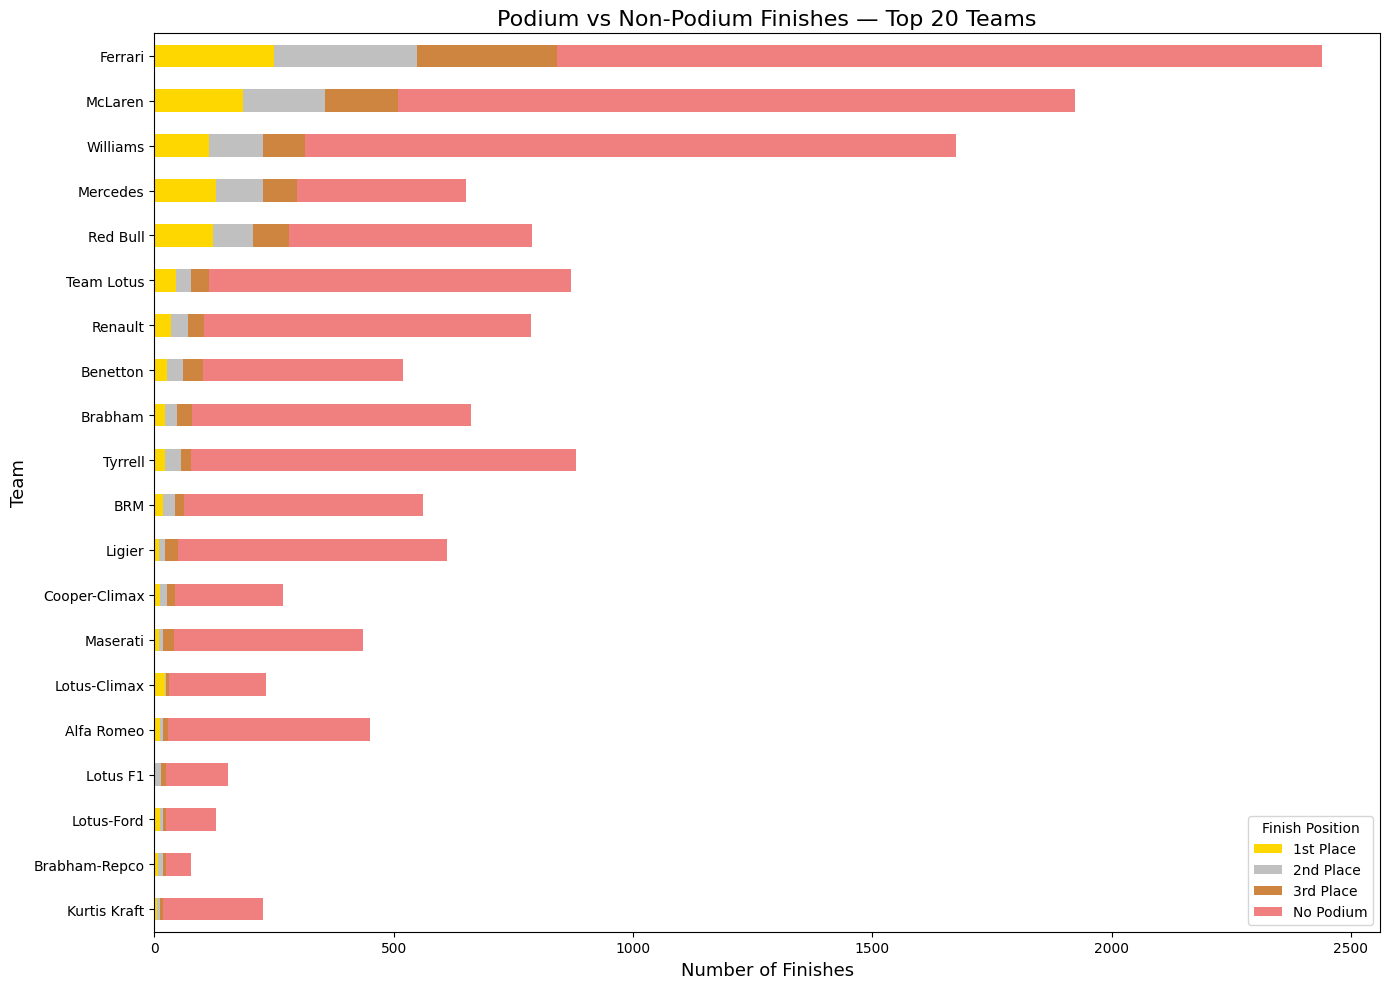

In [22]:

# Categorize podium finishes
def categorize_podium(pos):
    if pos == 1:
        return "1st Place"
    elif pos == 2:
        return "2nd Place"
    elif pos == 3:
        return "3rd Place"
    else:
        return "No Podium"

df["podium_category"] = df["positionOrder"].apply(categorize_podium)

# Aggregate counts by team and podium category
podium_counts = df.groupby(["constructorName", "podium_category"]).size().unstack(fill_value=0)

# Sort teams by total podium finishes and keep top 20
podium_counts["TotalPodiums"] = podium_counts[["1st Place", "2nd Place", "3rd Place"]].sum(axis=1)
top_teams = podium_counts.sort_values(by="TotalPodiums", ascending=False).head(20)
top_teams = top_teams.drop(columns="TotalPodiums")

# Plot stacked bar chart (horizontal)
colors = ["gold", "silver", "peru", "lightcoral"]
ax = top_teams.plot(
    kind="barh",
    stacked=True,
    figsize=(14, 10),
    color=colors
)

plt.title("Podium vs Non-Podium Finishes — Top 20 Teams", fontsize=16)
plt.ylabel("Team", fontsize=13)
plt.xlabel("Number of Finishes", fontsize=13)
plt.legend(title="Finish Position", loc="lower right")
plt.gca().invert_yaxis()  # Highest podium teams at the top
plt.tight_layout()
plt.show()


From the stacked bar chart we made, we can visually see the ratio a team has between podiums (1st place, 2nd place, and 3rd place) and no podiums. For our predictions, we should expect a higher ratio of no podiums compared to podiums based off of the chart.

### **1.3 Splitting 80/20**

Now that the data is easier to read for us (Luke and Tiffany), we can take this data and divide it into training and testing data using an 80% training and 20% testing split.

In [20]:
# Load the cleaned dataset
df = pd.read_csv("/Users/tiffany/Desktop/CS 5324/CS 5324 Datasets/f1_cleaned.csv")

# Features and target variable
X = df.drop(columns=["podium", "positionOrder"])
y = df["podium"]

# For now, we'll encode categorical variables using one-hot encoding
X = pd.get_dummies(X, columns=["raceName", "driverName", "constructorName"], drop_first=True)

# Train-test split with stratification (80% train, 20% split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df["podium"]) # stratify to maintain class distribution 

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (21407, 1126)
Test set shape: (5352, 1126)


In [21]:
# Get all one-hot encoded columns
one_hot_encoded_columns = [col for col in X.columns if col.startswith("raceName_") or col.startswith("driverName_") or col.startswith("constructorName_")]
print("One-hot encoded columns:", one_hot_encoded_columns)

X = X.drop(columns=one_hot_encoded_columns)
print("Number of one-hot encoded columns:", len(one_hot_encoded_columns))

One-hot encoded columns: ['raceName_Abu Dhabi Grand Prix', 'raceName_Argentine Grand Prix', 'raceName_Australian Grand Prix', 'raceName_Austrian Grand Prix', 'raceName_Azerbaijan Grand Prix', 'raceName_Bahrain Grand Prix', 'raceName_Belgian Grand Prix', 'raceName_Brazilian Grand Prix', 'raceName_British Grand Prix', 'raceName_Caesars Palace Grand Prix', 'raceName_Canadian Grand Prix', 'raceName_Chinese Grand Prix', 'raceName_Dallas Grand Prix', 'raceName_Detroit Grand Prix', 'raceName_Dutch Grand Prix', 'raceName_Eifel Grand Prix', 'raceName_Emilia Romagna Grand Prix', 'raceName_European Grand Prix', 'raceName_French Grand Prix', 'raceName_German Grand Prix', 'raceName_Hungarian Grand Prix', 'raceName_Indian Grand Prix', 'raceName_Indianapolis 500', 'raceName_Italian Grand Prix', 'raceName_Japanese Grand Prix', 'raceName_Korean Grand Prix', 'raceName_Las Vegas Grand Prix', 'raceName_Luxembourg Grand Prix', 'raceName_Malaysian Grand Prix', 'raceName_Mexican Grand Prix', 'raceName_Mexico

### **1.3.1 Why the 80/20 Split is Appropriate**

We argue for using an 80/20 split for this dataset.

The Formula 1 results dataset contains data from many seasons and hundreds of races dating back from 1950s, which means the sample size is large enough to allocate 20% for testing without sacrificing too much training data. Using 80% of the data for training allows for the logisitc regression model to learn from a wide range of drivers, constructors, and circuits, while 20 provides a sufficiently large and diverse set for evaluating model performance on unseen races.

Additionally, the dataset exhibits a moderate class imbalance, of which only 15% of the entires are podium finishes (top 3). By using stratified sampling, we ensure that both the training and testing sets preserve this natural imbalance. This makes our evaluation metrics more reliable and representative of real-world performance.

/Users/tiffany/miniconda3/envs/mlenv3_11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/tiffany/miniconda3/envs/mlenv3_11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/tiffany/miniconda3/envs/mlenv3_11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. A

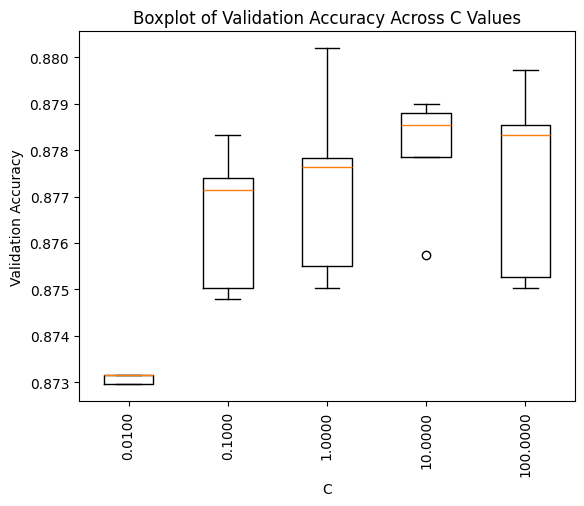

In [24]:
%matplotlib inline

# Define the range of C values (regularization strength)
costs = [0.01, 0.1, 1, 10, 100]  # This corresponds to the "C_values" in the previous code

# Store cross-validation scores for each C
accs = []  # This will store the cross-validation scores for each C

# Perform cross-validation for each value of C
for C in costs:
    model = LogisticRegression(C=C, solver='liblinear', penalty='l2', random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    accs.append(scores)  # Append the scores for this C

# Create the box plot
plt.boxplot(accs)
plt.xticks(range(1, len(costs) + 1), ['%.4f' % c for c in costs], rotation='vertical')
plt.xlabel('C')
plt.ylabel('Validation Accuracy')
plt.title('Boxplot of Validation Accuracy Across C Values')
plt.show()